In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee
import transit
import george
from george import kernels

I first read the data obtained with the Keck telescope into the frame data

In [2]:
newdata = pd.read_table('Keckdata.txt', skiprows=[0, 2], sep='\s+')

And I select the three important variables, with the option to add an error in quadrature

In [3]:
bjd = np.array(newdata['JD-2.44e6'], 'd')
rvs = np.array(newdata['mnvel'], 'd')
rverr = np.array(newdata['errvel'], 'd')
additionalerr = 0.0

Now I use the orbital ephemeris obtained from the transits to define the orbital phases, and I also define a new zero point for the BJD timestamps

In [4]:
period = 0.6892099
tc = 2454953.1910
tc = tc-2440000.0

phasesaux = (bjd-tc)/period
phases, orbit = np.modf(phasesaux)

phases = phases
bjdlv = np.mean(bjd)
bjdrest, bjdint = np.modf(bjdlv)

phi0 = (bjdint-tc)/period
aux, phi0 = phi0-np.modf(phi0)

shortbjd = bjd-bjdint

Now I define a function that calculates the log of the likelihood for the fit

In [98]:
def simplemodel(theta, phases):
    K, loggamma, logprot, h, sigma, logalpha  = theta
    return -K*np.sin(2.0*np.pi*phases)

In [99]:
def lnlike(theta, phases, shortbjd, rvs, error):
    "Model to fit a sinusoid to the RV data"
    K, loggamma, logprot, logh, sigma, logalpha= theta
    
    prot =  10**logprot
    gamma = 10**loggamma
    alpha = 10**logalpha
    h = 10**logh

    theoRV = simplemodel(theta, phases)
    
    gp = george.GP(kernels.WhiteKernel(sigma**2)+(kernels.ExpSquaredKernel(alpha**2)*
                                                  kernels.ExpSine2Kernel(1.0/gamma**2, prot))*h**2)
    gp.compute(shortbjd, error)
    return gp.lnlikelihood(rvs - simplemodel(theta, phases))

In [111]:
def lnprior(theta):
    K, loggamma, logprot, logh, sigma, logalpha= theta
    
    prot =  10**logprot
    gamma = 10**loggamma
    alpha = 10**logalpha
    h = 10**logh


    if  0.1 <= gamma <= 100 and 1 <= h and 0 < sigma and 0.1 < alpha <= 100 and 20 <= prot <= 45:
        return 0.0#-0.5*((prot-32.0)/1.0)**2
    return -np.inf

In [112]:
def lnprob(theta, phases, shortbjd, rvs, error):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, phases, shortbjd, rvs, error)

And I obtain the best fit parameters, their uncertainties, and I plot the observations and the model

In [113]:
nll = lambda *args: -lnprob(*args)
result = op.minimize(nll, [4.0, 1.0, np.log10(30.0), np.log10(5.0), 2.0, 0.5], 
                     args=(phases, shortbjd, rvs, rverr), tol=0.01, options={'disp': True, 'maxiter':100000}, method='BFGS')
K_ml, gamma_ml, prot_ml, h_ml, sigma_ml, alpha_ml = result["x"]
error = np.sqrt(rverr**2+ 0.0*sigma_ml**2)
print result["x"]

Optimization terminated successfully.
         Current function value: 69.866985
         Iterations: 5
         Function evaluations: 80
         Gradient evaluations: 10
[ 3.50090611  0.99608311  1.46962142  0.79651007  2.09996562  0.55119275]


With the best fit solution, it is time to run and MCMC routine to estimate the uncertainties on the parameters

In [120]:
ndim, nwalkers = 6, 100
pos = [result["x"]*(1+5e-3*np.random.randn(ndim)) for i in range(nwalkers)]

In [121]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(phases, shortbjd, rvs, rverr))
sampler.run_mcmc(pos, 20000);

In [122]:
samples = sampler.chain[:, 2000:, :].reshape((-1, ndim)) #Burn in portion to remove (currently %10)

Now I plot the results in a triangle plot 

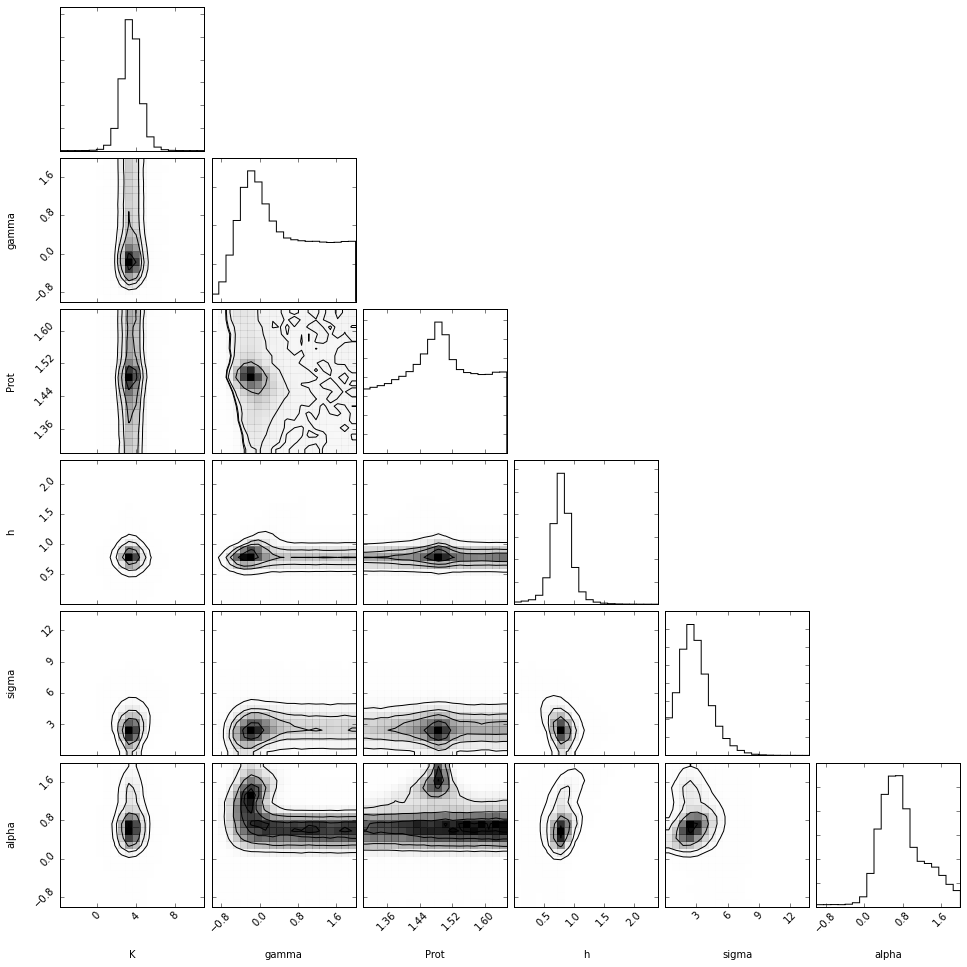

In [123]:
import triangle
fig = triangle.corner(samples, labels=["K", "gamma", "Prot", "h", "sigma", "alpha"]) #truths=[m_true, b_true, np.log(f_true)   , 
fig.savefig("triangle.png")

In [124]:
(K_mcmc, gamma_mcmc, prot_mcmc, h_mcmc, sigma_mcmc, alpha_mcmc) = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                                  zip(*np.percentile(samples, [15.86, 50, 84.14], axis=0)))

In [125]:
print('K value {0:3.2f} +{1:3.2f} - {1:3.2f}' .format(K_mcmc[0],K_mcmc[1], K_mcmc[2] ))

K value 3.52 +0.89 - 0.89


<Container object of 3 artists>

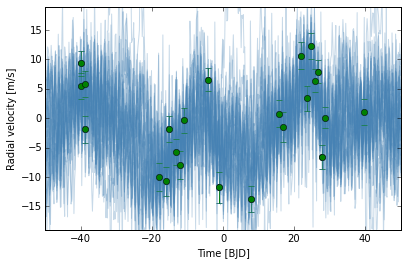

In [126]:
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(1,2,1)
ax.scatter(shortbjd, rvs)
ax.errorbar(shortbjd, rvs, yerr=error, fmt='o')
plt.xlim([-50, 50]) 
plt.ylim([-19, 19]) 

ax.set_xlabel('Time [BJD]')
ax.set_ylabel('Radial velocity [m/s]')

theoRV = -K_ml*np.sin(2.0*np.pi*phases) 

newbjd = np.linspace(-50, 50, 500)
newx = (newbjd/period) + phi0
newphases, orbit = np.modf(newx)



# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    # Set up the GP for this sample.
    K, loggamma, logprot, logh, sigma, logalpha= s
    
    prot =  10**logprot
    gamma = 10**loggamma
    alpha = 10**logalpha
    h = 10**logh

    gp = george.GP(kernels.WhiteKernel(sigma**2)+kernels.ExpSquaredKernel(alpha**2)*kernels.ExpSine2Kernel(gamma, prot)*h**2)
    gp.compute(shortbjd, error)
        
    # Compute the prediction conditioned on the observations and plot it.
    m = gp.sample_conditional(rvs - simplemodel(s, phases), newbjd ) + simplemodel(s, newbjd)
    ax.plot(newbjd, m, color="#4682b4", alpha=0.3)
    
    
ax.errorbar(shortbjd, rvs, yerr=error, fmt='o')